Energía ligada encontrada: -15.9521 MeV


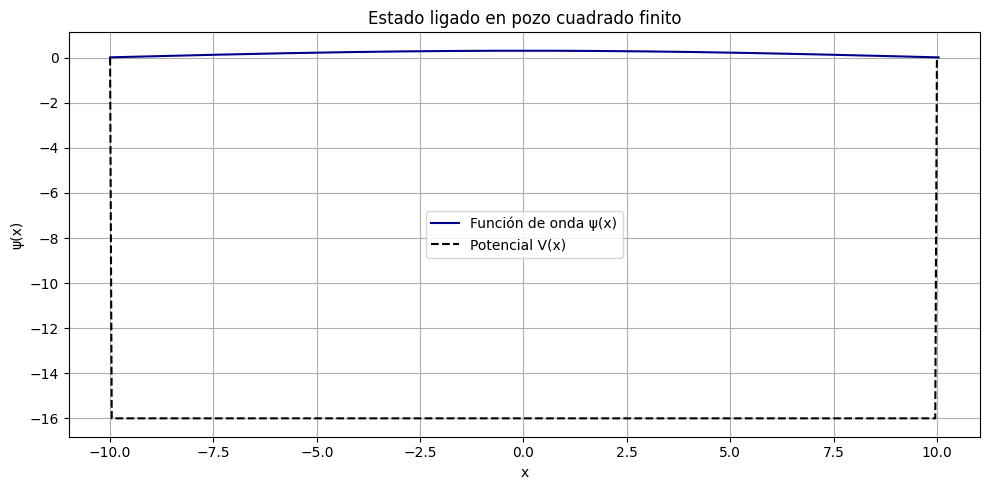

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos y numéricos
eps = 1E-3
n_steps = 501
h = 0.04
E = -17.0
Emax = 1.1 * E
Emin = E / 1.1
count_max = 100

# Definición del potencial del pozo
def V(x):
    return -16.0 if abs(x) < 10.0 else 0.0

# Ecuación de Schrödinger como sistema de primer orden
def f(x, y, F, E):
    F[0] = y[1]
    F[1] = -(0.4829)*(E - V(x)) * y[0]

# Método de Runge-Kutta 4
def rk4(t, y, h, Neqs, E):
    F = np.zeros(Neqs)
    ydumb = np.zeros(Neqs)
    k1 = np.zeros(Neqs)
    k2 = np.zeros(Neqs)
    k3 = np.zeros(Neqs)
    k4 = np.zeros(Neqs)

    f(t, y, F, E)
    for i in range(Neqs):
        k1[i] = h * F[i]
        ydumb[i] = y[i] + k1[i]/2.
    f(t + h/2., ydumb, F, E)
    for i in range(Neqs):
        k2[i] = h * F[i]
        ydumb[i] = y[i] + k2[i]/2.
    f(t + h/2., ydumb, F, E)
    for i in range(Neqs):
        k3[i] = h * F[i]
        ydumb[i] = y[i] + k3[i]
    f(t + h, ydumb, F, E)
    for i in range(Neqs):
        k4[i] = h * F[i]
        y[i] = y[i] + (k1[i] + 2*(k2[i] + k3[i]) + k4[i])/6.

# Diferencia de derivadas logarítmicas en el punto de empalme
def diff(E, h):
    y = np.zeros(2)
    i_match = n_steps // 3
    nL = i_match + 1

    # Desde la izquierda
    y[0] = 1e-15
    y[1] = y[0] * np.sqrt(-E * 0.4829)
    for ix in range(nL + 1):
        x = h * (ix - n_steps // 2)
        rk4(x, y, h, 2, E)
    left = y[1] / y[0]

    # Desde la derecha
    y[0] = 1e-15
    y[1] = -y[0] * np.sqrt(-E * 0.4829)
    for ix in range(n_steps, nL + 1, -1):
        x = h * (ix + 1 - n_steps // 2)
        rk4(x, y, -h, 2, E)
    right = y[1] / y[0]

    return (left - right) / (left + right)

# Búsqueda de energía ligada mediante bisección
for count in range(count_max):
    E = (Emax + Emin)/2.
    Diff = diff(E, h)
    if diff(Emax, h)*Diff > 0:
        Emax = E
    else:
        Emin = E
    if abs(Diff) < eps:
        break

print(f"Energía ligada encontrada: {E:.4f} MeV")

# Cálculo de la función de onda completa
def compute_wavefunction(E, h, n_steps):
    yL = np.zeros((n_steps+1, 2))
    yR = np.zeros((n_steps+1, 2))
    i_match = n_steps // 3
    x_vals = np.array([h * (i - n_steps // 2) for i in range(n_steps+1)])

    # Izquierda
    yL[0, 0] = 1e-15
    yL[0, 1] = yL[0, 0] * np.sqrt(-E * 0.4829)
    for i in range(1, i_match + 1):
        x = x_vals[i]
        y = yL[i-1].copy()
        rk4(x, y, h, 2, E)
        yL[i] = y

    # Derecha
    yR[n_steps, 0] = 1e-15
    yR[n_steps, 1] = -yR[n_steps, 0] * np.sqrt(-E * 0.4829)
    for i in range(n_steps-1, i_match-1, -1):
        x = x_vals[i+1]
        y = yR[i+1].copy()
        rk4(x, y, -h, 2, E)
        yR[i] = y

    # Escalamos para que se acoplen en el punto de empalme
    scale = yL[i_match,0] / yR[i_match,0]
    for i in range(i_match, n_steps+1):
        yR[i,0] *= scale

    # Ensamblamos la función de onda final
    psi = np.zeros(n_steps+1)
    for i in range(n_steps+1):
        if i <= i_match:
            psi[i] = yL[i,0]
        else:
            psi[i] = yR[i,0]

    # Normalización
    norm = np.sqrt(np.trapezoid(psi**2, x_vals))
    psi /= norm

    return x_vals, psi

# Obtener y graficar la función de onda
x, psi = compute_wavefunction(E, h, n_steps)

plt.figure(figsize=(10,5))
plt.plot(x, psi, label="Función de onda ψ(x)", color="darkblue")
plt.plot(x, [V(xi) for xi in x], label="Potencial V(x)", color="black", linestyle='--')
plt.title("Estado ligado en pozo cuadrado finito")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Estado fundamental (par):   E = -12.1509 MeV
Primer estado excitado (impar): E = -12.1509 MeV


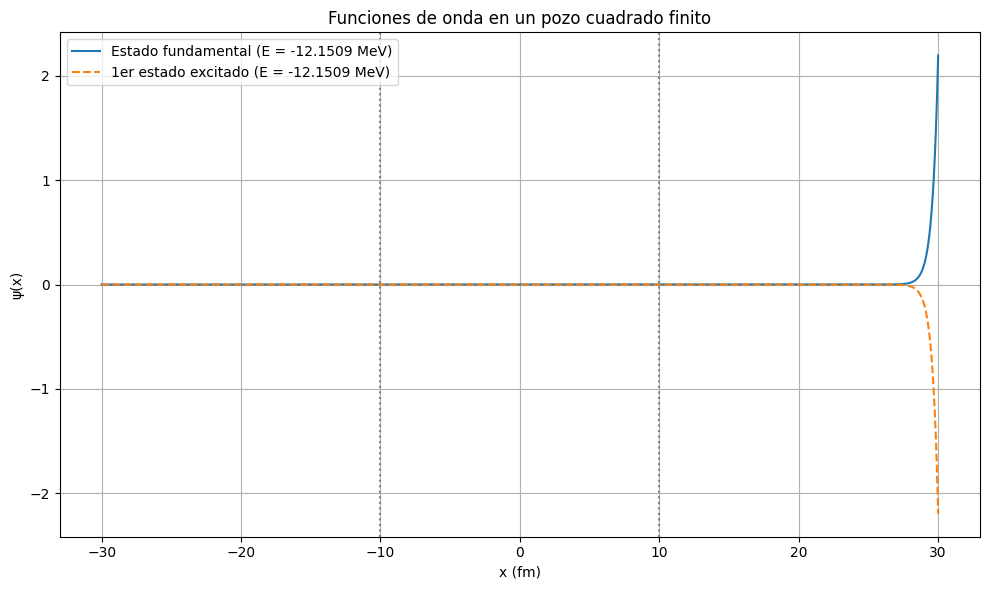

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

# Constantes del problema
m_hbar2 = 0.4829  # m/(ħc)^2 en MeV·fm⁻²
V0 = -16.0        # Profundidad del pozo (MeV)
a = 10.0          # Mitad del ancho del pozo (fm)
h = 0.04          # Paso para integración
n_steps = 1501    # Número de pasos para integración
eps = 1e-5        # Precisión para el método de bisección

# Potencial tipo pozo cuadrado finito
def V(x):
    return V0 if abs(x) < a else 0.0

# Derivadas para ecuación de Schrödinger
def f(x, y, E):
    return np.array([y[1], -m_hbar2 * (E - V(x)) * y[0]])

# Integración con RK4
def rk4_step(x, y, h, E):
    k1 = h * f(x, y, E)
    k2 = h * f(x + h/2, y + k1/2, E)
    k3 = h * f(x + h/2, y + k2/2, E)
    k4 = h * f(x + h, y + k3, E)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

# Diferencia entre derivadas logarítmicas izquierda y derecha
def diff(E, even=True):
    yL = np.zeros(2)
    yR = np.zeros(2)
    i_match = n_steps // 3
    x_match = (i_match - n_steps//2) * h

    # Condiciones iniciales izquierda
    yL[0] = 1e-15
    yL[1] = yL[0] * np.sqrt(-E * m_hbar2)
    if not even:
        yL[1] *= -1

    # Integrar desde la izquierda hasta el punto de empalme
    for i in range(i_match):
        x = (i - n_steps//2) * h
        yL = rk4_step(x, yL, h, E)

    left_slope = yL[1] / yL[0]

    # Condiciones iniciales derecha
    yR[0] = 1e-15
    yR[1] = yR[0] * np.sqrt(-E * m_hbar2)
    if not even:
        yR[1] *= -1

    # Integrar desde la derecha hacia el punto de empalme
    for i in range(n_steps-1, i_match, -1):
        x = (i - n_steps//2) * h
        yR = rk4_step(x, yR, -h, E)

    right_slope = yR[1] / yR[0]

    return (left_slope - right_slope) / (left_slope + right_slope)

# Encuentra energía para una raíz (estado ligado)
def find_energy(Emin, Emax, even=True):
    for _ in range(100):
        E = (Emin + Emax) / 2
        d = diff(E, even)
        if abs(d) < eps:
            return E
        elif diff(Emin, even) * d < 0:
            Emax = E
        else:
            Emin = E
    return E

# Calcula y normaliza la función de onda completa
def compute_wavefunction(E, even=True):
    y = np.zeros(2)
    psi = np.zeros(n_steps)
    x_vals = h * (np.arange(n_steps) - n_steps // 2)

    # Condiciones iniciales
    y[0] = 1e-15
    y[1] = y[0] * np.sqrt(-E * m_hbar2)
    if not even:
        y[1] *= -1

    # Integrar hacia adelante
    for i in range(n_steps):
        psi[i] = y[0]
        x = (i - n_steps//2) * h
        y = rk4_step(x, y, h, E)

    # Normalización
    norm = np.sqrt(trapezoid(psi**2, x_vals))
    psi /= norm

    return x_vals, psi

# Encuentra el estado fundamental (par) y primer excitado (impar)
E0 = find_energy(-17, -12, even=True)
x0, psi0 = compute_wavefunction(E0, even=True)

E1 = find_energy(-17, -12, even=False)
x1, psi1 = compute_wavefunction(E1, even=False)

print(f"Estado fundamental (par):   E = {E0:.4f} MeV")
print(f"Primer estado excitado (impar): E = {E1:.4f} MeV")

# Graficar funciones de onda
plt.figure(figsize=(10, 6))
plt.plot(x0, psi0, label=f'Estado fundamental (E = {E0:.4f} MeV)')
plt.plot(x1, psi1, label=f'1er estado excitado (E = {E1:.4f} MeV)', linestyle='--')
plt.axvline(-a, color='gray', linestyle=':')
plt.axvline(a, color='gray', linestyle=':')
plt.title("Funciones de onda en un pozo cuadrado finito")
plt.xlabel("x (fm)")
plt.ylabel("ψ(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()